In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
import itertools
import lightgbm as lgb

In [2]:
DIRECTORY = './data/'
categories = pd.read_csv(DIRECTORY + 'item_categories.csv')
items = pd.read_csv(DIRECTORY + 'items.csv')
shops = pd.read_csv(DIRECTORY + 'shops.csv')
train = pd.read_csv(DIRECTORY + 'sales_train.csv')

# Backtest Engine

In [54]:
# Remember, dont use train, only self.train
class BackTester:
    def __init__(self, train):
        date_train = train.copy()
        date_train['date'] = pd.to_datetime(date_train['date'], format='%d.%m.%Y')
        date_train['month'] = date_train['date'].dt.to_period('M')
        date_train = date_train.set_index('month')
        date_train = date_train.sort_index()

        self.train: pd.DataFrame = date_train
    
    """ 
    Takes in a function
    Function should take
        1. test df
        2. stores list, items list
        3. any optional arguments
    """
    def submit_predictor(self, predictor, **kwargs):
        self.predictor = predictor
        self.additional_args = kwargs
    
    def run_backtester(self):
        months = self.train.index.unique()
        mse_list = []
        output_list = []

        for index, month in enumerate(months):
            if index == len(months) - 1: continue # exclude last month (using full train set)
            # if month != pd.to_datetime('10-01-2014').to_period('M'): continue
            print(month)
            if index == 0: continue
            # if index > 3: continue

            # Get data, calculate answers
            # Use STORES present in BOTH, and ITEMS present in TEST
            sub_train = self.train.loc[:month, :]
            sub_test = self.train.loc[months[index+1],:]

            train_stores = sub_train['shop_id'].unique()
            test_stores = sub_test['shop_id'].unique()
            intersection_stores = np.intersect1d(train_stores, test_stores)

            train_items = sub_train['item_id'].unique()
            test_items = sub_test['item_id'].unique()

            # Call predictor
            # require that there is a 'prediction' column
            prediction = self.predictor(sub_train, intersection_stores, test_items, **self.additional_args)
            for col in ['prediction', 'shop_id', 'item_id']: assert(col in prediction.columns)

            # Get the actual answers and compute mse
            filtered_test = sub_test[sub_test['shop_id'].isin(intersection_stores)]
            test_aggregated = filtered_test.groupby(by=['shop_id', 'item_id'])['item_cnt_day'].sum().to_frame('answer').reset_index()
            test_answers = pd.DataFrame(data=itertools.product(intersection_stores, test_items), columns=['shop_id', 'item_id'])
            test_answers = test_answers.merge(test_aggregated, on=['shop_id', 'item_id'], how='left')
            test_answers['answer'] = np.clip(test_answers['answer'].fillna(0), 0, 20)
          
            mse_df = test_answers.merge(right=prediction, on=['shop_id', 'item_id'], how='left').fillna(0)
            mse_df['mse'] = np.square(mse_df['answer'] - mse_df['prediction'])
            print("MSE:", np.mean(mse_df['mse']))

            """
            Analytics calculations
            Goal: split into certain categories:
            1. items in test-not-train (totally new items) - all shops
            2. items-shop combo in train
            3. items-shop combo not in train, but item IS in train
            
            Split reasoning:
                all test items are included
                test-not-train are the newest ones (highest mse)
                remaining items are broken into whether they also were in the store before
            """

            train_shop_item_combo = sub_train[['shop_id', 'item_id']].drop_duplicates()
            all_rows = pd.DataFrame(data=itertools.product(intersection_stores, test_items), columns=['shop_id', 'item_id'])
            merge_indicator = all_rows.merge(train_shop_item_combo, on=['shop_id', 'item_id'], how='left', indicator=True)

            new_items = all_rows[~all_rows['item_id'].isin(train_items)]
            item_shop_both = all_rows[merge_indicator['_merge'] == 'both']
            item_not_shop = all_rows[
                    all_rows['item_id'].isin(train_items) &
                    (merge_indicator['_merge'] == 'left_only')
                ]
            
            mse_metrics = mse_df.copy()
            mse_metrics['type'] = -1
            for i, df in enumerate([new_items, item_shop_both, item_not_shop]):
                indicator = mse_metrics.merge(df, how='left', indicator=True)['_merge']
                mse_metrics.loc[indicator == 'both', 'type'] = i

            # Stats
            # 1. mse stats by item category
            mseBreakdown = mse_metrics.groupby(by='type')['mse'].agg(['sum', 'mean', 'count'])
            mseBreakdown = mseBreakdown.reset_index()
            mseBreakdown['month'] = months[index+1]
            mse_list.append(mseBreakdown)

            # 2. answer and prediction metrics by item category
            output_groups = mse_metrics.groupby(by='type')[['answer', 'prediction']].mean()
            output_groups = output_groups.reset_index()
            output_groups['month'] = months[index + 1]
            output_list.append(output_groups)

            # prints
            print(mseBreakdown['mean'])
            # print old vs. new items
            new_train_end = np.setdiff1d(sub_train.loc[month]['item_id'].unique(), sub_train.loc[:month-1]['item_id'].unique())
            mse_metrics['is_new_train_end'] = mse_metrics['item_id'].isin(new_train_end)

            display(mse_metrics[mse_metrics['type'] == 1].groupby('is_new_train_end')[['answer', 'prediction', 'mse']].agg(['mean', 'count', 'sum']))
            

        final_mse_df = pd.concat(mse_list, ignore_index=True)
        final_output_df = pd.concat(output_list, ignore_index=True)
        self.mse_df = final_mse_df
        self.output_df = final_output_df

    def display_stats(self):
        for col in self.mse_df.columns:
            if col in ['type', 'month']: continue
            
            pivot_df = self.mse_df.pivot(index='month', columns='type', values=col).fillna(0)
            pivot_df.plot(kind='bar', stacked=True, figsize=(15,5))
            plt.title(f'{col} RMSE across Item Types')

            print('')

        for col in self.output_df.columns:
            if col in ['type', 'month']: continue
            
            pivot_df = self.output_df.pivot(index='month', columns='type', values=col).fillna(0)
            pivot_df.plot(kind='bar', stacked=True, figsize=(15,5))
            plt.title(f'{col} Mean across Item Types')

b = BackTester(train)

def last_month(train: pd.DataFrame, stores, items):
    index = pd.MultiIndex.from_product([stores, items], names=['shop_id', 'item_id'])
    result = pd.DataFrame(index=index)
    last_month = train.index.unique().max()

    aggregated_train = train.loc[last_month,:].groupby(by=['shop_id', 'item_id'])['item_cnt_day'].sum().to_frame('prediction').reset_index()
    result = result.merge(aggregated_train, on=['shop_id', 'item_id'], how='left').fillna(0)
    result['prediction'] = np.clip(result['prediction'], 0, 20)
    return result

def last_n_months(train: pd.DataFrame, stores, items, num_months=2):
    index = pd.MultiIndex.from_product([stores, items], names=['shop_id', 'item_id'])
    result = pd.DataFrame(index=index)
    last_months = train.index.unique().sort_values()[-num_months:]

    aggregated_train = train.loc[last_months,:].groupby(by=['month', 'shop_id', 'item_id'])['item_cnt_day'].sum().to_frame('prediction').reset_index()
    aggregated_train = aggregated_train
    aggregated_train = (aggregated_train.groupby(by=['shop_id', 'item_id'])['prediction'].sum()/num_months).to_frame('prediction').reset_index()

    result = result.merge(aggregated_train, on=['shop_id', 'item_id'], how='left').fillna(0)
    result['prediction'] = np.clip(result['prediction'], 0, 20)

    return result

# for i in [1,2,3,6,12,24]:
#     b.submit_predictor(last_n_months, num_months=i)
#     b.run_backtester()
# b.submit_predictor(last_n_months, num_months=2)
# b.run_backtester()

# Somewhat intelligent final prediction

- For most products, we just want to guess last month sales (if they were released a few months ago, for example)
    - using last 2 months seems to eliminate noise, but this is likely from the "released last month" items which we will deal with anyways
- For products released LAST MONTH or in generaly RECENTLY
    - say they were released very end of october, we guess 
    - say they were released 2 weeks ago, use last week's daily avg, weighted more towards the more recent days
    - TRY: last week daily avg. weighted to recent

2013-01
2013-02
MSE: 1.5329561879941307
0    7.675011
1    2.772406
2    0.200361
Name: mean, dtype: float64


answer                 prediction                  \
                      mean  count      sum       mean  count      sum   
is_new_train_end                                                        
False             0.798763  82599  65977.0   1.136249  82599  93853.0   
True              1.932251   4620   8927.0   2.128355   4620   9833.0   

                       mse                   
                      mean  count       sum  
is_new_train_end                             
False             2.414654  82599  199448.0  
True              9.168506   4620   42358.5

2013-03
MSE: 1.2611684949422157
0    4.473518
1    2.734974
2    0.126366
Name: mean, dtype: float64


answer                  prediction                    \
                      mean   count      sum       mean   count       sum   
is_new_train_end                                                           
False             0.532045  109004  57995.0   0.989661  109004  107877.0   
True              2.075791    5845  12133.0   2.512746    5845   14687.0   

                       mse                    
                      mean   count       sum  
is_new_train_end                              
False             2.406792  109004  262350.0  
True              8.855261    5845   51759.0

2013-04
MSE: 1.0051817037142017
0    2.492869
1    1.936735
2    0.227718
Name: mean, dtype: float64


answer                  prediction                   \
                      mean   count      sum       mean   count      sum   
is_new_train_end                                                          
False             0.509275  123079  62681.0   0.695545  123079  85607.0   
True              2.413284    4065   9810.0   1.868512    4065   7595.5   

                        mse                     
                       mean   count        sum  
is_new_train_end                                
False              1.638590  123079  201676.00  
True              10.963899    4065   44568.25

2013-05
MSE: 1.1276912793897933
0    4.942373
1    1.923655
2    0.189427
Name: mean, dtype: float64


answer                  prediction                   \
                      mean   count      sum       mean   count      sum   
is_new_train_end                                                          
False             0.529738  138425  73329.0   0.640730  138425  88693.0   
True              2.908180    2494   7253.0   1.981957    2494   4943.0   

                        mse                    
                       mean   count       sum  
is_new_train_end                               
False              1.693422  138425  234412.0  
True              14.702285    2494   36667.5

2013-06
MSE: 0.9340228383726042
0    2.197743
1    1.890878
2    0.124132
Name: mean, dtype: float64


answer                  prediction                   \
                      mean   count      sum       mean   count      sum   
is_new_train_end                                                          
False             0.516642  149380  77176.0   0.635313  149380  94903.0   
True              2.455791    3721   9138.0   1.980516    3721   7369.5   

                        mse                     
                       mean   count        sum  
is_new_train_end                                
False              1.672239  149380  249799.00  
True              10.668167    3721   39696.25

2013-07
MSE: 1.153987326886094
0    5.768983
1    1.770858
2    0.114055
Name: mean, dtype: float64


answer                  prediction                   \
                      mean   count      sum       mean   count      sum   
is_new_train_end                                                          
False             0.553417  152189  84224.0   0.639974  152189  97397.0   
True              2.336855    2461   5751.0   1.377692    2461   3390.5   

                       mse                     
                      mean   count        sum  
is_new_train_end                               
False             1.655474  152189  251945.00  
True              8.906237    2461   21918.25

2013-08
MSE: 1.5064647875402066
0    14.851736
1     1.594299
2     0.112441
Name: mean, dtype: float64


answer                  prediction                   \
                      mean   count      sum       mean   count      sum   
is_new_train_end                                                          
False             0.440536  158087  69643.0   0.623973  158087  98642.0   
True              2.687826    3450   9273.0   2.052029    3450   7079.5   

                        mse                     
                       mean   count        sum  
is_new_train_end                                
False              1.382372  158087  218535.00  
True              11.305290    3450   39003.25

2013-09
MSE: 1.2549501734599384
0    5.805844
1    1.567510
2    0.142286
Name: mean, dtype: float64


answer                  prediction                   \
                      mean   count      sum       mean   count      sum   
is_new_train_end                                                          
False             0.395935  161322  63873.0   0.529810  161322  85470.0   
True              3.110388    4149  12905.0   3.154736    4149  13089.0   

                        mse                    
                       mean   count       sum  
is_new_train_end                               
False              1.276497  161322  205927.0  
True              12.882743    4149   53450.5

2013-10
MSE: 1.457685333992665
0    10.796910
1     1.564012
2     0.139509
Name: mean, dtype: float64


answer                  prediction                   \
                      mean   count      sum       mean   count      sum   
is_new_train_end                                                          
False             0.389597  167473  65247.0   0.496289  167473  83115.0   
True              2.973161    4732  14069.0   2.111052    4732   9989.5   

                        mse                     
                       mean   count        sum  
is_new_train_end                                
False              1.170290  167473  195992.00  
True              15.498468    4732   73338.75

2013-11
MSE: 1.7501894684394095
0    7.148507
1    2.441968
2    0.303513
Name: mean, dtype: float64


answer                   prediction                   \
                      mean   count       sum       mean   count      sum   
is_new_train_end                                                           
False             0.608765  176173  107248.0   0.491420  176173  86575.0   
True              3.941650    4593   18104.0   2.732528    4593  12550.5   

                        mse                     
                       mean   count        sum  
is_new_train_end                                
False              1.982443  176173  349253.00  
True              20.067875    4593   92171.75

2013-12
MSE: 1.3299836474293645
0    2.453791
1    2.387175
2    0.074685
Name: mean, dtype: float64


answer                  prediction                    \
                      mean   count      sum       mean   count       sum   
is_new_train_end                                                           
False             0.500818  172961  86622.0   0.790612  172961  136745.0   
True              1.745599    5794  10114.0   1.824819    5794   10573.0   

                       mse                    
                      mean   count       sum  
is_new_train_end                              
False             2.289516  172961  395997.0  
True              5.302468    5794   30722.5

2014-01
MSE: 1.1597661535086115
0    4.388868
1    1.694643
2    0.130938
Name: mean, dtype: float64


answer                  prediction                    \
                      mean   count      sum       mean   count       sum   
is_new_train_end                                                           
False             0.469755  172175  80880.0   0.589470  172175  101492.0   
True              3.039185    1276   3878.0   1.419279    1276    1811.0   

                        mse                    
                       mean   count       sum  
is_new_train_end                               
False              1.603891  172175  276150.0  
True              13.940047    1276   17787.5

2014-02
MSE: 1.379392266202379
0    9.715989
1    1.609486
2    0.231358
Name: mean, dtype: float64


answer                  prediction                   \
                      mean   count      sum       mean   count      sum   
is_new_train_end                                                          
False             0.411820  172828  71174.0   0.519517  172828  89787.0   
True              3.177794    2711   8615.0   1.702693    2711   4616.0   

                        mse                    
                       mean   count       sum  
is_new_train_end                               
False              1.353733  172828  233963.0  
True              17.913869    2711   48564.5

2014-03
MSE: 1.1736803095167798
0    6.893809
1    1.513109
2    0.130975
Name: mean, dtype: float64


answer                  prediction                   \
                      mean   count      sum       mean   count      sum   
is_new_train_end                                                          
False             0.351382  167325  58795.0   0.517346  167325  86565.0   
True              2.268261    3053   6925.0   2.511628    3053   7668.0   

                        mse                    
                       mean   count       sum  
is_new_train_end                               
False              1.346266  167325  225264.0  
True              10.657222    3053   32536.5

2014-04
MSE: 1.0209553829011035
0    9.882848
1    1.121981
2    0.098011
Name: mean, dtype: float64


answer                  prediction                   \
                      mean   count      sum       mean   count      sum   
is_new_train_end                                                          
False             0.365213  169222  61802.0   0.419254  169222  70947.0   
True              2.029271    3348   6794.0   1.952957    3348   6538.5   

                       mse                     
                      mean   count        sum  
is_new_train_end                               
False             1.001271  169222  169437.00  
True              7.223193    3348   24183.25

2014-05
MSE: 0.8501148551023463
0    4.744132
1    1.185857
2    0.096720
Name: mean, dtype: float64


answer                  prediction                   \
                      mean   count      sum       mean   count      sum   
is_new_train_end                                                          
False             0.383019  170942  65474.0   0.432930  170942  74006.0   
True              3.543645    2612   9256.0   2.574464    2612   6724.5   

                        mse                     
                       mean   count        sum  
is_new_train_end                                
False              0.991904  170942  169558.00  
True              13.879116    2612   36252.25

2014-06
MSE: 0.9328230006266612
0    3.181671
1    1.351290
2    0.119196
Name: mean, dtype: float64


answer                  prediction                   \
                      mean   count      sum       mean   count      sum   
is_new_train_end                                                          
False             0.375009  172780  64794.0   0.458369  172780  79197.0   
True              2.326792    2650   6166.0   1.542075    2650   4086.5   

                        mse                     
                       mean   count        sum  
is_new_train_end                                
False              1.218573  172780  210545.00  
True              10.004434    2650   26511.75

2014-07
MSE: 0.9874524595316675
0    6.116480
1    1.307782
2    0.117873
Name: mean, dtype: float64


answer                  prediction                   \
                      mean   count      sum       mean   count      sum   
is_new_train_end                                                          
False             0.440601  167083  73617.0   0.451009  167083  75356.0   
True              2.045757    2404   4918.0   1.482945    2404   3565.0   

                       mse                    
                      mean   count       sum  
is_new_train_end                              
False             1.210267  167083  202215.0  
True              8.085275    2404   19437.0

2014-08
MSE: 1.3598006918135397
0    10.745758
1     1.426105
2     0.079393
Name: mean, dtype: float64


answer                  prediction                   \
                      mean   count      sum       mean   count      sum   
is_new_train_end                                                          
False             0.367630  155398  57129.0   0.531693  155398  82624.0   
True              1.833069    2522   4623.0   1.855670    2522   4680.0   

                       mse                    
                      mean   count       sum  
is_new_train_end                              
False             1.341645  155398  208489.0  
True              6.630254    2522   16721.5

2014-09
MSE: 1.2488522879944526
0    4.310985
1    1.423019
2    0.390630
Name: mean, dtype: float64


answer                  prediction                   \
                      mean   count      sum       mean   count      sum   
is_new_train_end                                                          
False             0.360541  157050  56623.0   0.413289  157050  64907.0   
True              3.099065    3422  10605.0   2.698860    3422   9235.5   

                        mse                     
                       mean   count        sum  
is_new_train_end                                
False              1.000497  157050  157128.00  
True              20.814363    3422   71226.75

2014-10
MSE: 1.4758003796267005
0    10.711348
1     1.295245
2     0.114461
Name: mean, dtype: float64


answer                  prediction                   \
                      mean   count      sum       mean   count      sum   
is_new_train_end                                                          
False             0.402292  154281  62066.0   0.452058  154281  69744.0   
True              1.685730    3742   6308.0   1.841529    3742   6891.0   

                       mse                    
                      mean   count       sum  
is_new_train_end                              
False             1.116716  154281  172288.0  
True              8.655933    3742   32390.5

2014-11
MSE: 1.6530083270249811
0    5.490339
1    2.252190
2    0.330218
Name: mean, dtype: float64


answer                  prediction                   \
                      mean   count      sum       mean   count      sum   
is_new_train_end                                                          
False             0.621744  158689  98664.0   0.459963  158689  72991.0   
True              3.443448    5243  18054.0   2.579630    5243  13525.0   

                        mse                    
                       mean   count       sum  
is_new_train_end                               
False              1.831475  158689  290635.0  
True              14.985886    5243   78571.0

2014-12
MSE: 1.4295162078514416
0    0.861117
1    2.527458
2    0.106923
Name: mean, dtype: float64


answer                  prediction                    \
                      mean   count      sum       mean   count       sum   
is_new_train_end                                                           
False             0.499562  159636  79748.0   0.799851  159636  127685.0   
True              1.879737    5014   9425.0   1.719984    5014    8624.0   

                       mse                    
                      mean   count       sum  
is_new_train_end                              
False             2.360614  159636  376839.0  
True              7.839450    5014   39307.0

2015-01
MSE: 1.1698475064466776
0    4.709469
1    1.673771
2    0.135763
Name: mean, dtype: float64


answer                  prediction                   \
                      mean   count      sum       mean   count      sum   
is_new_train_end                                                          
False             0.416816  155673  64887.0   0.581430  155673  90513.0   
True              2.789960     757   2112.0   1.096433     757    830.0   

                        mse                    
                       mean   count       sum  
is_new_train_end                               
False              1.609579  155673  250568.0  
True              14.874505     757   11260.0

2015-02
MSE: 0.9127843386757788
0    4.766498
1    1.107717
2    0.086802
Name: mean, dtype: float64


answer                  prediction                   \
                      mean   count      sum       mean   count      sum   
is_new_train_end                                                          
False             0.387182  153602  59472.0   0.452481  153602  69502.0   
True              1.887020    1903   3591.0   1.705728    1903   3246.0   

                       mse                    
                      mean   count       sum  
is_new_train_end                              
False             1.015429  153602  155972.0  
True              8.556752    1903   16283.5

2015-03
MSE: 1.181338684860824
0    8.130989
1    1.350440
2    0.076979
Name: mean, dtype: float64


answer                  prediction                   \
                      mean   count      sum       mean   count      sum   
is_new_train_end                                                          
False             0.306506  142477  43670.0   0.453238  142477  64576.0   
True              1.871434    2839   5313.0   1.715041    2839   4869.0   

                       mse                    
                      mean   count       sum  
is_new_train_end                              
False             1.224366  142477  174444.0  
True              7.677527    2839   21796.5

2015-04
MSE: 1.0920749229948548
0    8.428889
1    1.184350
2    0.106237
Name: mean, dtype: float64


answer                  prediction                   \
                      mean   count      sum       mean   count      sum   
is_new_train_end                                                          
False             0.330525  133884  44252.0   0.376042  133884  50346.0   
True              2.008897    2248   4516.0   2.505783    2248   5633.0   

                        mse                    
                       mean   count       sum  
is_new_train_end                               
False              0.965926  133884  129322.0  
True              14.193060    2248   31906.0

2015-05
MSE: 0.8877659527036668
0    4.195349
1    1.112579
2    0.098924
Name: mean, dtype: float64


answer                  prediction                   \
                      mean   count      sum       mean   count      sum   
is_new_train_end                                                          
False             0.349147  129298  45144.0   0.389952  129298  50420.0   
True              2.456461    1803   4429.0   2.580422    1803   4652.5   

                        mse                     
                       mean   count        sum  
is_new_train_end                                
False              0.971384  129298  125598.00  
True              11.238075    1803   20262.25

2015-06
MSE: 0.7563207493588595
0    1.968503
1    1.097593
2    0.117453
Name: mean, dtype: float64


answer                  prediction                   \
                      mean   count      sum       mean   count      sum   
is_new_train_end                                                          
False             0.364683  130571  47617.0   0.398189  130571  51992.0   
True              2.010565    1893   3806.0   1.590597    1893   3011.0   

                       mse                    
                      mean   count       sum  
is_new_train_end                              
False             1.013050  130571  132275.0  
True              6.928949    1893   13116.5

2015-07
MSE: 0.8688506824029534
0    2.751266
1    1.172147
2    0.132430
Name: mean, dtype: float64


answer                  prediction                   \
                      mean   count      sum       mean   count      sum   
is_new_train_end                                                          
False             0.417812  120954  50536.0   0.431180  120954  52153.0   
True              1.506427    1167   1758.0   1.246358    1167   1454.5   

                       mse                     
                      mean   count        sum  
is_new_train_end                               
False             1.127048  120954  136321.00  
True              5.846401    1167    6822.75

2015-08
MSE: 1.1157748507923442
0    7.088018
1    1.176109
2    0.100906
Name: mean, dtype: float64


answer                  prediction                   \
                      mean   count      sum       mean   count      sum   
is_new_train_end                                                          
False             0.348129  120145  41826.0   0.459511  120145  55208.0   
True              1.814255    1852   3360.0   1.341523    1852   2484.5   

                       mse                     
                      mean   count        sum  
is_new_train_end                               
False             1.088551  120145  130784.00  
True              6.856237    1852   12697.75

2015-09
MSE: 1.2042724448893491
0    4.231922
1    1.274620
2    0.468791
Name: mean, dtype: float64


answer                  prediction                   \
                      mean   count      sum       mean   count      sum   
is_new_train_end                                                          
False             0.349559  115082  40228.0   0.398246  115082  45831.0   
True              2.026835    1975   4003.0   2.406835    1975   4753.5   

                        mse                     
                       mean   count        sum  
is_new_train_end                                
False              1.117942  115082  128655.00  
True              10.404177    1975   20548.25

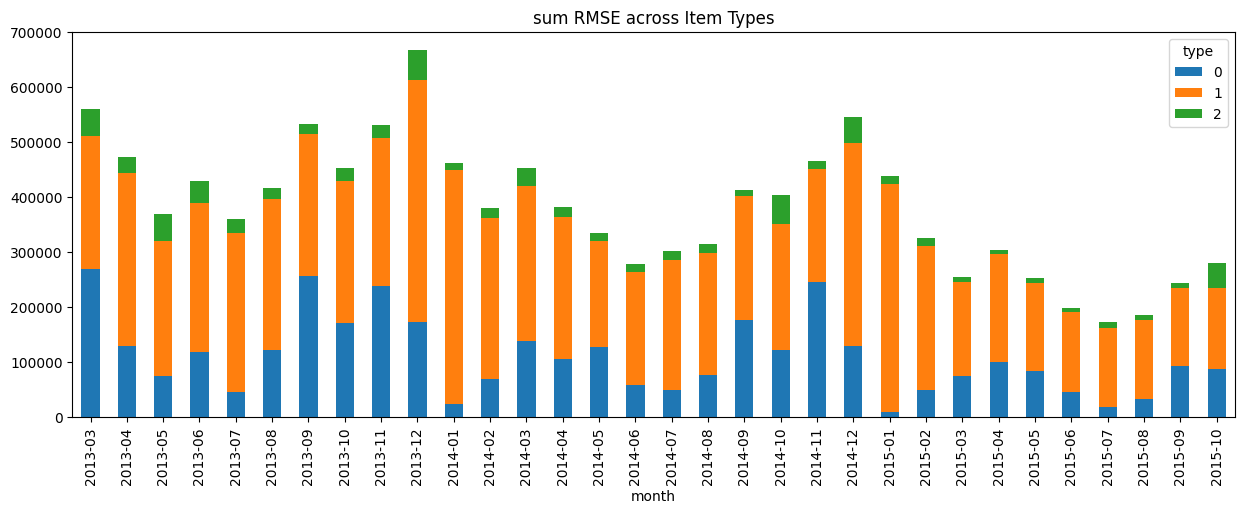

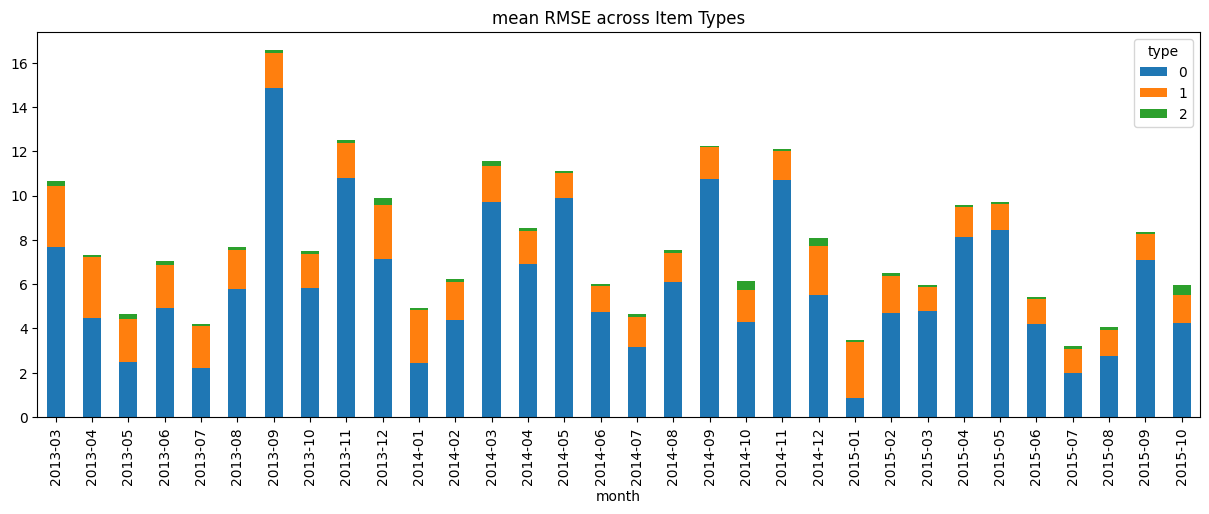

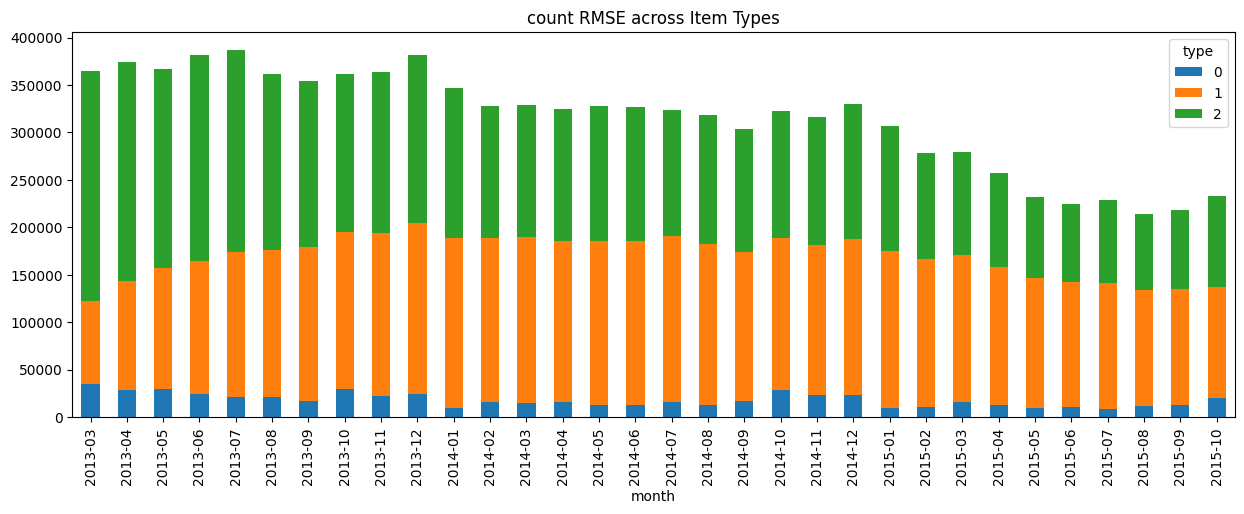

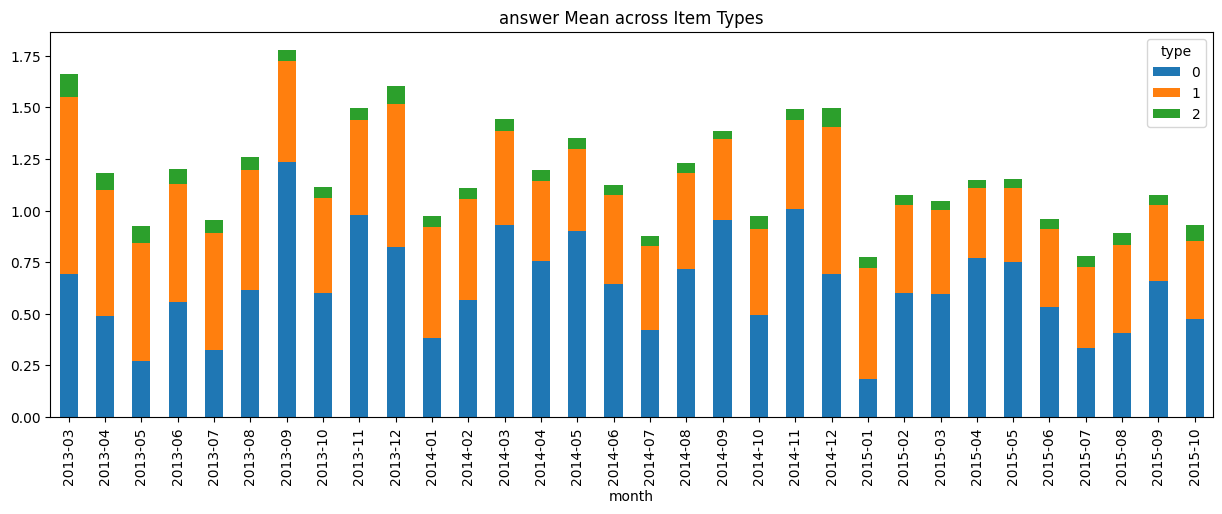

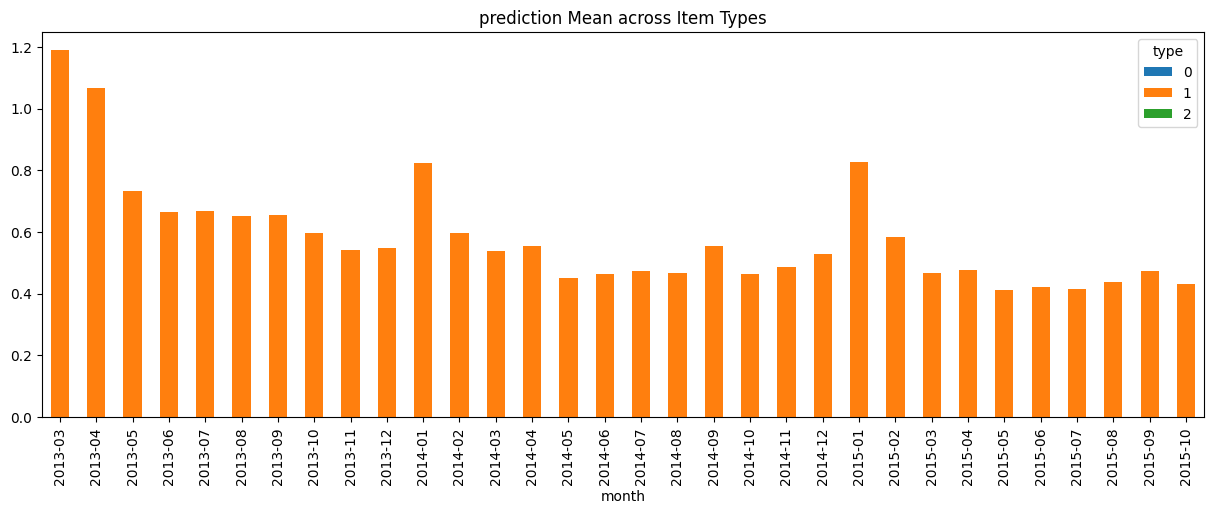

In [56]:
def final_prediction(train: pd.DataFrame, stores, items):
    # was it released in OCTOBER (last month of train?)
    # if so, predict based on the last x days of train, averaged
    # otherwise, predict last  month

    # BEFORE LAST MONTH predictions
    month = train.index.max()
    new_train_end = np.setdiff1d(train.loc[month]['item_id'].unique(), train.loc[:month-1]['item_id'].unique())
    old_predictions = train[~train['item_id'].isin(new_train_end)].loc[month].groupby(['item_id', 'shop_id'])['item_cnt_day'].sum()

    # BEFORE LAST MONTH
    last_day = train['date'].max()
    # new_predictions = train[train['item_id'].isin(new_train_end) & (train['date'] == last_day)].groupby(['item_id', 'shop_id'])['item_cnt_day'].sum()
    new_predictions = train[train['item_id'].isin(new_train_end)].loc[month].groupby(['item_id', 'shop_id'])['item_cnt_day'].sum()/2

    # put it together
    index = pd.MultiIndex.from_product([stores, items], names=['shop_id', 'item_id'])
    result = pd.DataFrame(index=index)
    result = result.merge(old_predictions, on=['shop_id', 'item_id'], how='left').fillna(0)
    result = result.merge(new_predictions, on=['shop_id', 'item_id'], how='left').fillna(0)
    result['prediction'] = np.clip(result['item_cnt_day_x'] + result['item_cnt_day_y'], 0, 20)
    return result.reset_index()

b.submit_predictor(final_prediction)
b.run_backtester()
b.display_stats()